# Diabetes Classifier

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Overview

In [2]:
data = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# EDA

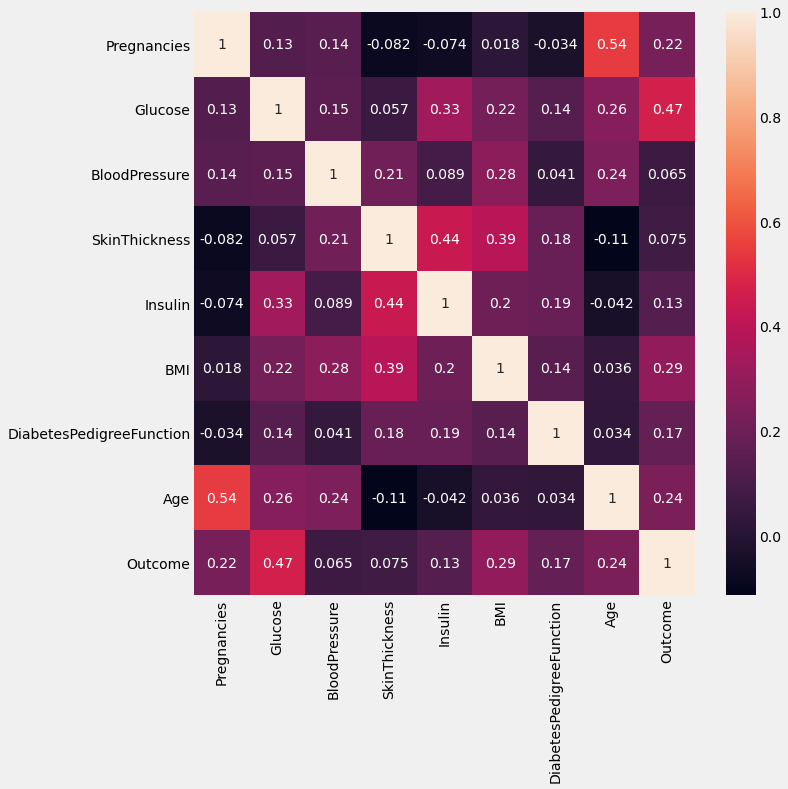

In [5]:
corr = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.show()

The most correlated feature with outcome is glucose. Some feature engineering may help to get better results.

In [6]:
data["pr-age"] = data["Pregnancies"]/data["Age"]
data.drop("Pregnancies", axis=1, inplace=True)
data["bl-gl"] = data["Glucose"]/data["BloodPressure"]
data.drop("BloodPressure", axis=1,inplace=True)
data["bmi-age"] = data["BMI"]/data["Age"]
data.head()

,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,pr-age,bl-gl,bmi-age
0,148,35,0,33.6,0.627,50,1,0.120000,2.055556,0.672000
1,85,29,0,26.6,0.351,31,0,0.032258,1.287879,0.858065
2,183,0,0,23.3,0.672,32,1,0.250000,2.859375,0.728125
3,89,23,94,28.1,0.167,21,0,0.047619,1.348485,1.338095
4,137,35,168,43.1,2.288,33,1,0.000000,3.425000,1.306061


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


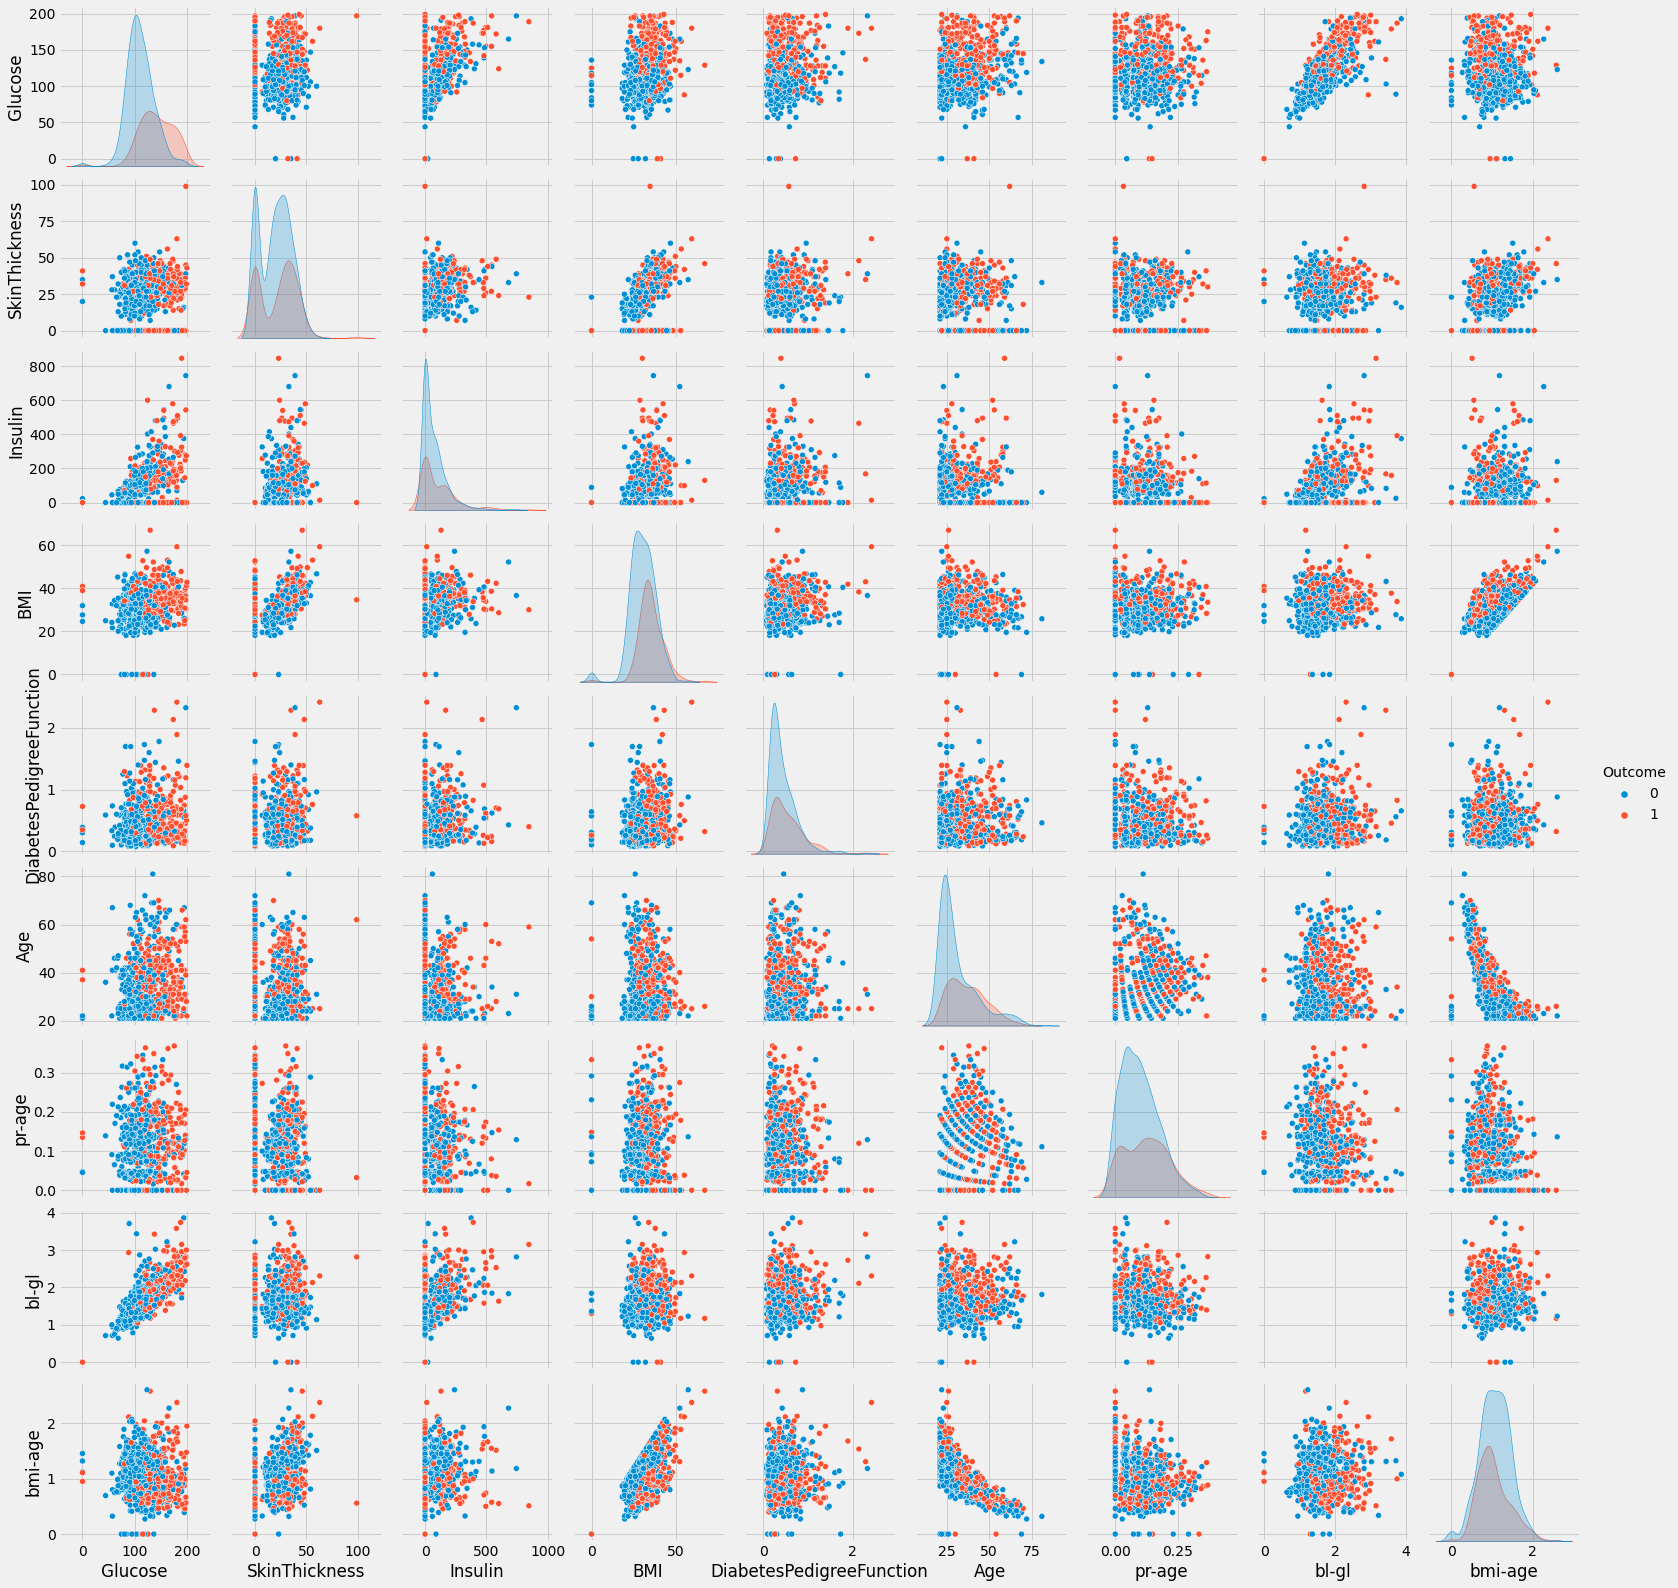

In [7]:
sns.pairplot(data, hue="Outcome")

There are a lot of outliers. We can clean some of them.

In [8]:
shape1 = data.shape

for column in data.columns:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3-q1
    minimum = q1-(1.5*iqr)
    maximum = q3+(1.5*iqr)
    
    min_in = data[data[column] < minimum].index
    max_in = data[data[column] > maximum].index
    
    data.drop(min_in, inplace=True)
    data.drop(max_in, inplace=True)

shape2 = data.shape

outliers = shape1[0]-shape2[0]

print("Total count of outliers have deleted: ",outliers)

Total count of outliers have deleted:  141


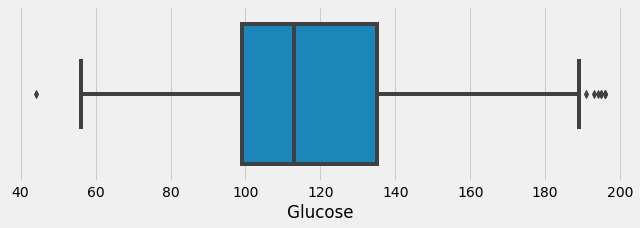

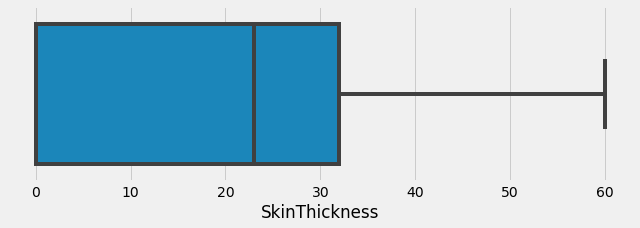

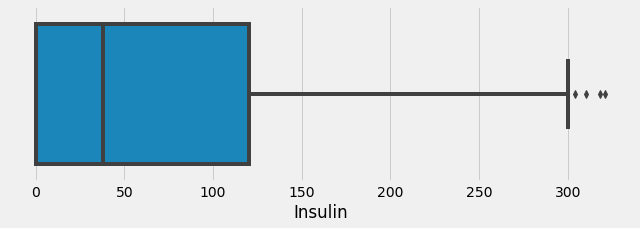

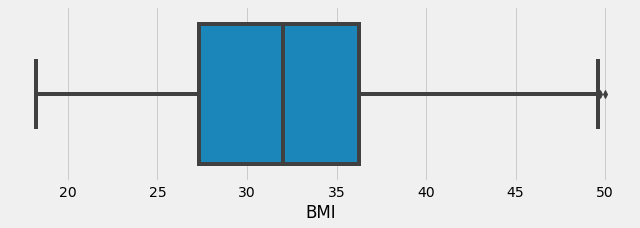

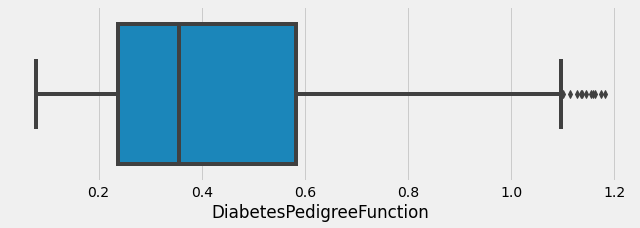

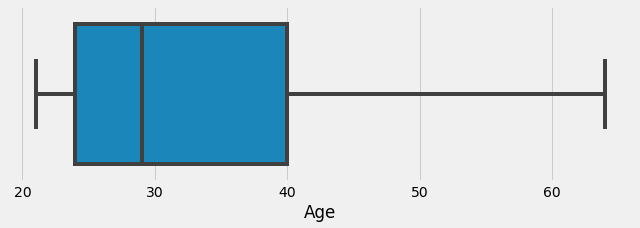

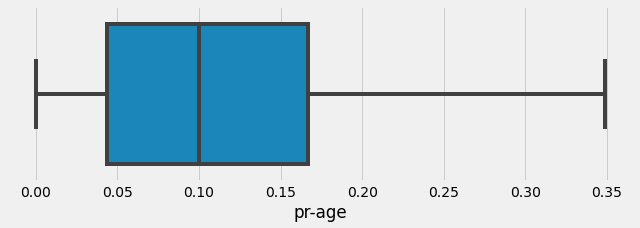

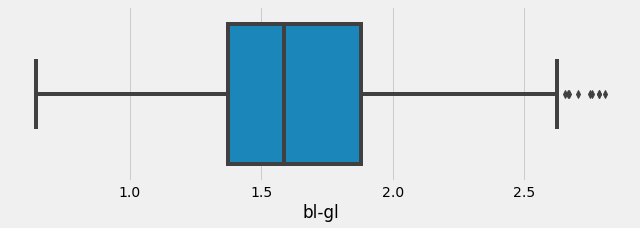

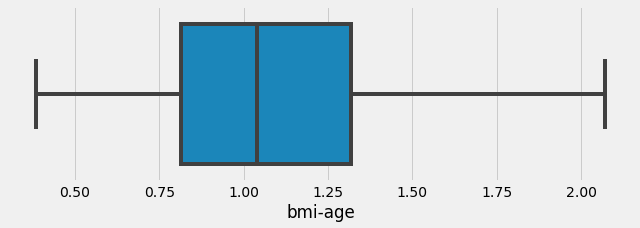

In [9]:
for col in data.columns:
    if col != "Outcome":
        plt.figure(figsize=(10,3))
        sns.boxplot(x=data[col], hue=data["Outcome"])
        plt.show()

# Split and Scaling

In [10]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=17)

# Random Forest Classifier

In [11]:
params = {"n_estimators": np.linspace(10, 250, 241, dtype="int"), "min_samples_split": np.linspace(2, 10, 9, dtype="int")}

rfc = RandomForestClassifier()
gscv = GridSearchCV(rfc, params, cv=10)
gscv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  8...
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 22

In [12]:
gscv.best_params_

{'min_samples_split': 5, 'n_estimators': 119}

In [13]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024714,0.001403,0.001761,0.000027,2,10,"{'min_samples_split': 2, 'n_estimators': 10}",0.765957,0.808511,0.765957,0.808511,0.723404,0.702128,0.723404,0.787234,0.808511,0.765957,0.765957,0.036852,1836
1,0.026310,0.000301,0.001850,0.000030,2,11,"{'min_samples_split': 2, 'n_estimators': 11}",0.765957,0.702128,0.744681,0.723404,0.744681,0.765957,0.829787,0.765957,0.829787,0.808511,0.768085,0.040871,1803
2,0.028417,0.000312,0.001945,0.000051,2,12,"{'min_samples_split': 2, 'n_estimators': 12}",0.765957,0.808511,0.638298,0.744681,0.680851,0.808511,0.829787,0.765957,0.765957,0.787234,0.759574,0.056333,2072
3,0.030935,0.000344,0.002033,0.000034,2,13,"{'min_samples_split': 2, 'n_estimators': 13}",0.723404,0.787234,0.680851,0.744681,0.765957,0.765957,0.702128,0.744681,0.723404,0.808511,0.744681,0.036852,2163
4,0.033466,0.000845,0.002639,0.001403,2,14,"{'min_samples_split': 2, 'n_estimators': 14}",0.744681,0.787234,0.702128,0.702128,0.723404,0.744681,0.872340,0.680851,0.744681,0.829787,0.753191,0.057249,2136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,0.464591,0.005317,0.018269,0.000177,10,246,"{'min_samples_split': 10, 'n_estimators': 246}",0.744681,0.744681,0.680851,0.744681,0.787234,0.787234,0.765957,0.851064,0.808511,0.787234,0.770213,0.043396,1477
2165,0.478875,0.009582,0.019359,0.001279,10,247,"{'min_samples_split': 10, 'n_estimators': 247}",0.765957,0.787234,0.702128,0.765957,0.787234,0.787234,0.808511,0.808511,0.829787,0.787234,0.782979,0.032686,210
2166,0.471455,0.005668,0.018494,0.000272,10,248,"{'min_samples_split': 10, 'n_estimators': 248}",0.744681,0.787234,0.702128,0.765957,0.787234,0.787234,0.787234,0.765957,0.829787,0.787234,0.774468,0.031844,1028
2167,0.471066,0.006258,0.018893,0.000947,10,249,"{'min_samples_split': 10, 'n_estimators': 249}",0.744681,0.829787,0.723404,0.765957,0.787234,0.787234,0.808511,0.808511,0.808511,0.808511,0.787234,0.031558,73


In [14]:
rfc = RandomForestClassifier(**gscv.best_params_)
rfc.fit(X_train, y_train)
print("Train Accuracy: ",accuracy_score(y_train, rfc.predict(X_train))*100)

Train Accuracy:  98.93617021276596


In [15]:
fi = {'Glucose':[], 'SkinThickness':[], 'Insulin':[], 'BMI':[],
       'DiabetesPedigreeFunction':[], 'Age':[], 'pr-age':[], 'bl-gl':[], 'bmi-age':[]}

for i,col in enumerate(data.drop("Outcome", axis=1).columns):
    fi[col].append(rfc.feature_importances_[i]*100)
    
pd.DataFrame(fi)

,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,pr-age,bl-gl,bmi-age
0,22.095241,5.439535,4.790825,13.206337,9.21081,13.399673,9.15535,12.533609,10.168621


In [16]:
pred = rfc.predict(X_test)
print("Test Accuracy: ",accuracy_score(y_test, pred))

Test Accuracy:  0.7898089171974523


There is an overoverfitting case. We need to fix this.

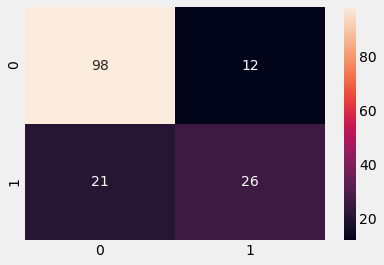

<Figure size 360x360 with 0 Axes>

In [17]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True)
plt.figure(figsize=(5,5))
plt.show()

In [18]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.68      0.55      0.61        47

    accuracy                           0.79       157
   macro avg       0.75      0.72      0.73       157
weighted avg       0.78      0.79      0.78       157



In [19]:
data["Outcome"].value_counts()

0    434
1    193
Name: Outcome, dtype: int64

As it's expected, there aren't enough class 1 observations for model to distinguish them. I will use StratifiedKFold instead GridSearchCV this time.

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rfc.fit(X_train, y_train)
        lst_accu_stratified.append(rfc.score(X_test, y_test))

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      np.mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', np.std(lst_accu_stratified))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  13  14  15  16  17  18  19
  20  21  22  23  25  26  27  28  30  33  34  35  36  37  38  39  42  43
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  67  69  70  71  72  73  74  76  77  78  80  81  83  84  86  88
  89  90  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 110 112 113 114 115 116 117 118 120 121 122 125 126 127 128 129 130
 131 132 133 134 135 136 137 139 140 141 142 143 144 145 147 148 149 150
 151 152 153 154 155 156 157 158 160 161 162 163 165 166 167 168 170 171
 173 174 175 176 177 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 200 201 202 203 204 205 206 208 210 211 212 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 231 232 233 234 236
 237 239 240 241 242 243 245 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 271 272 273 274 275 276 277 278
 279 281 283 284 285 286 289 290 291 293 294

# Neural Network

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [22]:
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
16/16 [==============================] - 1s 38ms/step - loss: 0.7055 - accuracy: 0.4973 - val_loss: 0.5758 - val_accuracy: 0.7760
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5686 - accuracy: 0.7534 - val_loss: 0.4971 - val_accuracy: 0.7840
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5297 - accuracy: 0.7469 - val_loss: 0.4394 - val_accuracy: 0.8240
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4950 - accuracy: 0.7651 - val_loss: 0.4082 - val_accuracy: 0.8240
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4913 - accuracy: 0.7560 - val_loss: 0.3906 - val_accuracy: 0.8400
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4427 - accuracy: 0.7890 - val_loss: 0.3908 - val_accuracy: 0.8240
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4589 - accuracy: 0.7852 - val_loss: 0.3794 - val_accuracy: 0.8400
Epoch 8/100


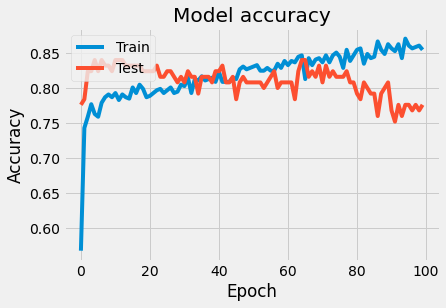

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

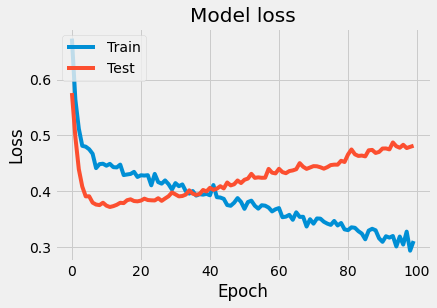

In [25]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='best') 
plt.show()